# Bearing Failure Prediction - Forecasting with RNNs

> Beware: This Notebook is hosted on Google Colab, so files are not persited. You need to "Runtime > Run all" cells to proceed.

## Download dataset

It can take up to 5 minutes to download and decompress raw data

TODO: Download 2nd and 3rd experiment datasets

In [ ]:
!wget -O data.7z https://ti.arc.nasa.gov/c/3/
!7z e data.7z
!unrar x -Y 1st_test.rar

--2022-01-17 19:06:06--  https://ti.arc.nasa.gov/c/3/
Resolving ti.arc.nasa.gov (ti.arc.nasa.gov)... 128.102.105.66, 2001:4d0:6311:2227:14b6:372b:2078:2a94
Connecting to ti.arc.nasa.gov (ti.arc.nasa.gov)|128.102.105.66|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://ti.arc.nasa.gov/m/project/prognostic-repository/IMS.7z [following]
--2022-01-17 19:06:07--  https://ti.arc.nasa.gov/m/project/prognostic-repository/IMS.7z
Reusing existing connection to ti.arc.nasa.gov:443.
HTTP request sent, awaiting response... 200 OK
Length: 1075320408 (1.0G)
Saving to: ‘data.7z’

data.7z             100%[===================>]   1.00G  9.07MB/s    in 2m 12s  

2022-01-17 19:08:19 (7.74 MB/s) - ‘data.7z’ saved [1075320408/1075320408]


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M 

In [ ]:
import glob
import datetime

import numpy as np
import pandas as pd
import scipy.stats as sts
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

## Preview single timeframe

Each data set consists of individual files that are 1-second vibration signal snapshots recorded at specific intervals. Each file consists of 20,480 points with the sampling rate set at 20 kHz. The file name indicates when the data was collected. Each record (row) in the data file is a data point.

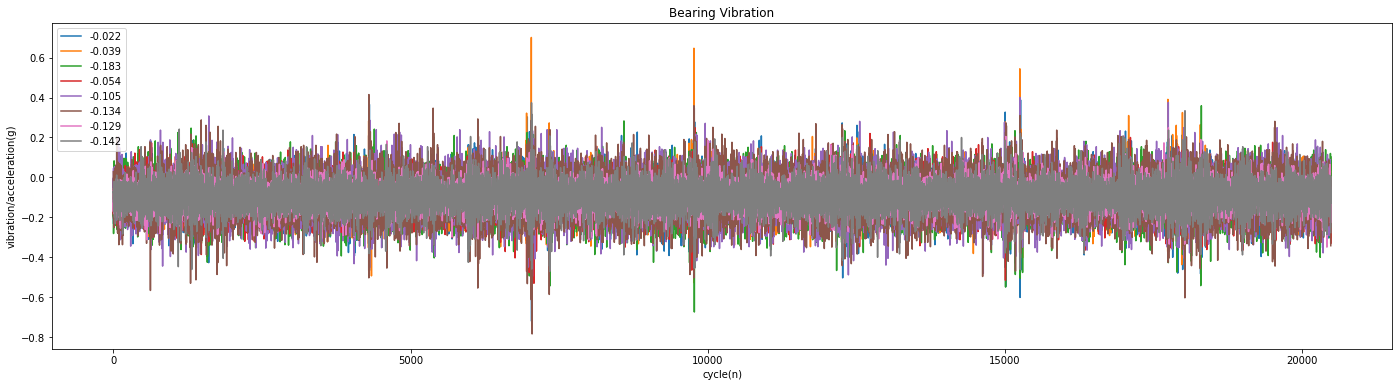

In [ ]:
dataset = pd.read_csv('/content/1st_test/2003.10.22.12.06.24', sep='\t')
ax = dataset.plot(figsize = (24,6), title= "Bearing Vibration" , legend = True)
ax.set(xlabel="cycle(n)", ylabel="vibration/acceleration(g)")
plt.show()

# Preprocessing

- Load dataset to pandas DataFrame
- Compute basic column-wise summary statistics

  - Absolute mean
  - Standard deviation
  - Kurtosis: Length of the tails of a signal distribution, or equivalently, how outlier prone the signal is. Developing faults can increase the number of outliers, and therefore increase the value of the kurtosis metric.
  - Skewness: Asymmetry of a signal distribution. Faults can impact distribution symmetry and therefore increase the level of skewness.
  - Entropy

In [ ]:
DATASET_DIR_PATH = r'/content/1st_test'

COLUMNS = ['b1_x','b1_y','b2_x', 'b2_y','b3_x','b3_y','b4_x', 'b4_y']

# First 43 files were taken every 5 minutes
SKIP_FIRST_NTH_FILES = 43
SAMPLE_EVERY_NTH_ROW = 45

FEATURES = {
  'abs_mean': lambda x: np.abs(x).mean(),
  'std': np.std,
  'skwe': sts.skew,
  'kurt': sts.kurtosis,
  'entropy': lambda x: sts.entropy(pd.cut(x, 10).value_counts())
}

# We are taking every nth row of each file for performance reasons
def skip_row(x, n):
  if x % n == 0:
    return False
  return True

def extract_datetime_from_path(path):
  segments = path.split('/')
  filename = segments[-1]
  return datetime.datetime.strptime(filename, "%Y.%m.%d.%H.%M.%S")

def extract_col_stats_features(df, columns=COLUMNS):
  dfs_reshaped = []
  for name, func in FEATURES.items():
    applied = np.array(df.apply(func))
    columns = [c+'_'+name for c in COLUMNS]
    df_reshaped = pd.DataFrame(applied.reshape(1,8), columns=columns)
    dfs_reshaped.append(df_reshaped)

  return pd.concat(dfs_reshaped, axis=1)

def read_file(path, n):
  dfs = []
  time = 0
  files = glob.glob(DATASET_DIR_PATH + "/*")
  for filename in files:
    df_raw = pd.read_csv(filename, index_col=None, header=None, sep='\t', skiprows=lambda x:skip_row(x, n))
    df = extract_col_stats_features(df_raw)
    df['datetime'] = extract_datetime_from_path(filename)
    dfs.append(df)
  return dfs

data = pd.concat(read_file(path, SAMPLE_EVERY_NTH_ROW), ignore_index=True)
data.set_index('datetime')

,b1_x_abs_mean,b1_y_abs_mean,b2_x_abs_mean,b2_y_abs_mean,b3_x_abs_mean,b3_y_abs_mean,b4_x_abs_mean,b4_y_abs_mean,b1_x_std,b1_y_std,b2_x_std,b2_y_std,b3_x_std,b3_y_std,b4_x_std,b4_y_std,b1_x_skwe,b1_y_skwe,b2_x_skwe,b2_y_skwe,b3_x_skwe,b3_y_skwe,b4_x_skwe,b4_y_skwe,b1_x_kurt,b1_y_kurt,b2_x_kurt,b2_y_kurt,b3_x_kurt,b3_y_kurt,b4_x_kurt,b4_y_kurt,b1_x_entropy,b1_y_entropy,b2_x_entropy,b2_y_entropy,b3_x_entropy,b3_y_entropy,b4_x_entropy,b4_y_entropy
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2003-10-31 01:59:46,0.125493,0.124537,0.126377,0.120706,0.130066,0.136114,0.118774,0.118895,0.098590,0.084182,0.091830,0.086697,0.112396,0.119170,0.076280,0.079926,0.293099,0.577285,0.035881,-0.439947,0.053972,0.144509,-0.049217,-0.003027,1.091969,1.790504,-0.072499,2.892329,0.759240,0.575087,0.871130,1.428745,1.714363,1.712222,1.961552,1.499464,1.787717,1.829498,1.731208,1.656718
2003-11-23 09:56:56,0.122550,0.127614,0.131035,0.123164,0.137555,0.142726,0.143732,0.141254,0.094975,0.090867,0.094605,0.078284,0.121061,0.127659,0.137573,0.140987,0.029117,-0.147571,0.163280,0.085772,-0.082159,0.075018,-0.001027,-0.135766,-0.031795,0.760148,-0.305191,0.112026,0.343150,0.735210,0.939891,0.593268,1.925255,1.693130,2.025643,1.818846,1.880099,1.651677,1.717237,1.777601
2003-10-29 15:39:46,0.129371,0.132647,0.129814,0.119004,0.132417,0.132818,0.116607,0.221520,0.098281,0.089781,0.100693,0.077375,0.106042,0.119435,0.072000,0.075905,0.322121,0.013733,-0.155328,0.007356,0.110034,-0.036612,0.049322,-0.095441,1.650780,1.286079,0.966364,0.302543,-0.261109,0.334973,0.682703,1.879630,1.585778,1.597541,1.699695,1.857556,1.980824,1.843757,1.661208,1.555985
2003-11-09 13:05:58,0.132454,0.123167,0.122316,0.126561,0.139129,0.131862,0.120860,0.120531,0.102037,0.087970,0.087458,0.077435,0.110737,0.110064,0.069671,0.084085,-0.457623,-0.221000,-0.020844,-0.030953,-0.351969,0.089431,0.071838,0.771403,1.809167,0.149694,-0.179287,1.198970,3.023568,-0.075056,0.643324,4.805815,1.669216,1.862571,1.940187,1.633174,1.466088,1.974738,1.701310,1.422133
2003-11-15 14:58:46,0.129627,0.126544,0.128932,0.124303,0.132285,0.136853,0.122136,0.117895,0.100451,0.086616,0.087185,0.074894,0.113105,0.122314,0.078468,0.076342,-0.132945,0.141554,-0.018959,0.395530,0.171986,0.120275,-0.020487,0.107480,0.749608,0.569126,-0.116230,0.785735,3.536188,1.115935,0.168121,0.303722,1.635571,1.814722,1.961978,1.796313,1.354452,1.640226,1.856092,1.817830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003-11-21 11:58:36,0.123445,0.126088,0.126842,0.122654,0.128070,0.139066,0.136579,0.130357,0.093202,0.094711,0.095076,0.076341,0.108275,0.119696,0.124727,0.114107,-0.001573,-0.209036,-0.401547,0.166726,-0.054305,0.216016,0.354722,1.250778,0.119419,0.792897,1.396726,1.141032,0.729664,0.297378,10.092948,6.323199,1.921016,1.692103,1.667938,1.651357,1.784023,1.851544,1.154395,1.459888
2003-11-16 17:08:46,0.123702,0.128410,0.123482,0.128114,0.129026,0.135888,0.115629,0.123901,0.098441,0.091088,0.094848,0.079472,0.106879,0.120188,0.069738,0.080726,0.344868,-0.164714,0.043363,0.067509,-0.083765,-0.030309,0.187969,0.066704,0.796578,0.133489,0.504550,0.418293,0.207958,0.385039,0.377261,2.198882,1.712428,1.947224,1.732483,1.776857,1.828922,1.800390,1.918694,1.518108
2003-11-21 10:58:36,0.135809,0.124274,0.128763,0.116921,0.129877,0.136489,0.128886,0.135844,0.102269,0.091845,0.092591,0.076157,0.108055,0.118472,0.128183,0.119001,-0.169984,0.186476,-0.079988,-0.165239,-0.018565,-0.146754,1.490952,-0.711158,2.759111,0.719237,-0.170530,0.507997,-0.186585,0.366018,13.098851,5.104502,1.448797,1.712072,2.015450,1.780788,1.926811,1.896977,1.201546,1.425259


## Scope dataset to single bearning

In [ ]:
bearing_columns = data.columns[pd.Series(data.columns).str.startswith('b4_')]
columns = bearing_columns.tolist() + ['datetime']
data = data[columns]

## Dataset exploration

In [ ]:
data.describe()

,b4_x_abs_mean,b4_y_abs_mean,b4_x_std,b4_y_std,b4_x_skwe,b4_y_skwe,b4_x_kurt,b4_y_kurt,b4_x_entropy,b4_y_entropy
count,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000
mean,0.124469,0.125234,0.091686,0.095062,0.004016,0.021302,1.909614,1.865016,1.682978,1.668802
std,0.014762,0.014092,0.029182,0.025621,0.443146,0.375791,4.908419,3.472521,0.176934,0.176729
min,0.046476,0.068342,0.054487,0.059556,-6.719142,-5.014030,-0.401723,-0.297128,0.508107,0.508514
25%,0.117475,0.118383,0.072741,0.078527,-0.136505,-0.137688,0.607956,0.664204,1.602998,1.582617
50%,0.121029,0.122410,0.078454,0.083250,0.009975,0.012082,1.033363,1.169547,1.711486,1.694843
75%,0.129576,0.131985,0.101093,0.106857,0.160781,0.171174,1.773306,1.915400,1.800370,1.792560
max,0.228189,0.227539,0.277338,0.202152,5.287915,2.312658,111.246322,75.372405,2.050107,2.076517


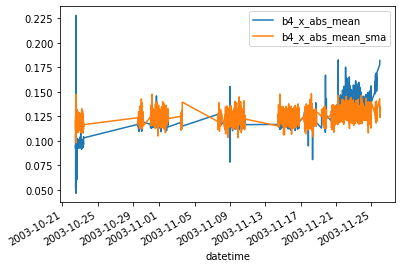

In [ ]:
data_ma = pd.DataFrame()
data_ma['b4_x_abs_mean'] = data['b4_x_abs_mean']
data_ma['b4_x_abs_mean_sma'] = data_ma['b4_x_abs_mean'].rolling(window=5).mean()
data_ma['datetime'] = data['datetime']

data_ma.plot(x="datetime", y=['b4_x_abs_mean','b4_x_abs_mean_sma'])

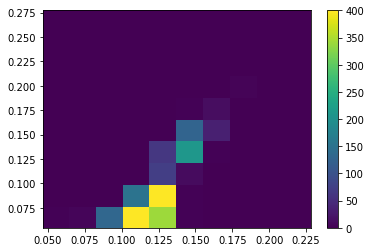

In [ ]:
plt.hist2d(data['b4_x_abs_mean'], data['b4_x_std'], bins=(10, 10), vmax=400)
plt.colorbar()

In [ ]:
data = data.drop('datetime', 1)

## Split the data

You'll use a (70%, 20%, 10%) split for the training, validation, and test sets. Note the data is not being randomly shuffled before splitting. This is for two reasons:

- It ensures that chopping the data into windows of consecutive samples is still possible.
- It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

In [ ]:
column_indices = {name: i for i, name in enumerate(data.columns)}

n = len(data)
train_df = data[0:int(n*0.7)]
val_df = data[int(n*0.7):int(n*0.9)]
test_df = data[int(n*0.9):]

num_features = data.shape[1]

## Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling: subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

## Windowing

ML model will make a set of predictions based on a window of consecutive samples from the data

Main features of the input window are:
- the width (number of time steps) of the input and label window
- the time offset between them
- which features are used as inputs, labels or both

Typically, data in TensorFlow is packed into arrays where the outermost index is across examples (the "batch" dimension). The middle indices are the "time" or "space" (width, height) dimension(s). The innermost indices are the features.

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
    
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def plot(self, model=None, plot_col=None, max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time')

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds
  
  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result


# Single step models

In [ ]:
val_performance = {}
performance = {}

In [ ]:
single_step_window = WindowGenerator(
  input_width=1,
  label_width=1,
  shift=1,
  label_columns=['b4_x_std']
)
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['b4_x_std']

In [ ]:
wide_window = WindowGenerator(
  input_width=24,
  label_width=24,
  shift=1,
  label_columns=['b4_x_abs_mean']
)

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['b4_x_abs_mean']

## Baseline

Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [ ]:
baseline = Baseline(label_index=column_indices['b4_x_abs_mean'])

baseline.compile(
  loss=tf.losses.MeanSquaredError(),
  metrics=[tf.metrics.MeanAbsoluteError()]
)

val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

14/14 [==============================] - 0s 3ms/step - loss: 2.0822 - mean_absolute_error: 1.0381


In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 8)
Output shape: (32, 24, 1)


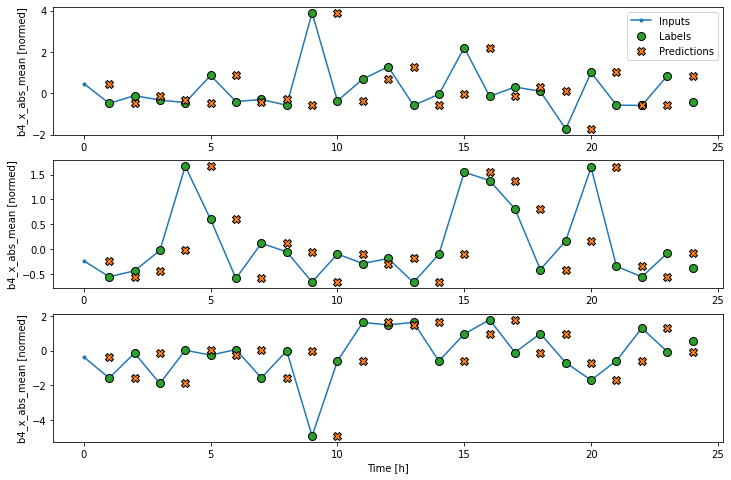

In [ ]:
wide_window.plot(baseline, plot_col='b4_x_abs_mean')

## Linear

The simplest trainable model you can apply to this task is to insert linear transformation between the input and output. 

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 8)
Output shape: (32, 1, 1)


In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
48/48 [==============================] - 1s 9ms/step - loss: 1.5524 - mean_absolute_error: 0.9350 - val_loss: 1.3904 - val_mean_absolute_error: 0.8967
Epoch 2/20
48/48 [==============================] - 0s 8ms/step - loss: 1.4860 - mean_absolute_error: 0.9194 - val_loss: 1.3411 - val_mean_absolute_error: 0.8825
Epoch 3/20
48/48 [==============================] - 0s 7ms/step - loss: 1.4284 - mean_absolute_error: 0.9048 - val_loss: 1.2993 - val_mean_absolute_error: 0.8695
Epoch 4/20
48/48 [==============================] - 0s 8ms/step - loss: 1.3775 - mean_absolute_error: 0.8920 - val_loss: 1.2608 - val_mean_absolute_error: 0.8587
Epoch 5/20
48/48 [==============================] - 0s 7ms/step - loss: 1.3312 - mean_absolute_error: 0.8815 - val_loss: 1.2283 - val_mean_absolute_error: 0.8499
Epoch 6/20
48/48 [==============================] - 0s 8ms/step - loss: 1.2886 - mean_absolute_error: 0.8726 - val_loss: 1.1980 - val_mean_absolute_error: 0.8437
Epoch 7/20
48/48 [==========

One advantage to linear models is that they're relatively simple to interpret. You can pull out the layer's weights and visualize the weight assigned to each input

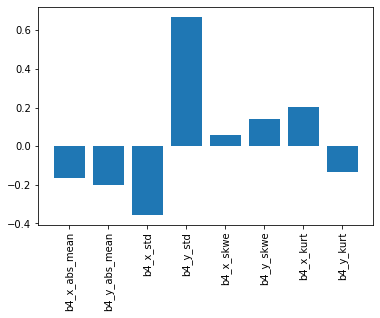

In [ ]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

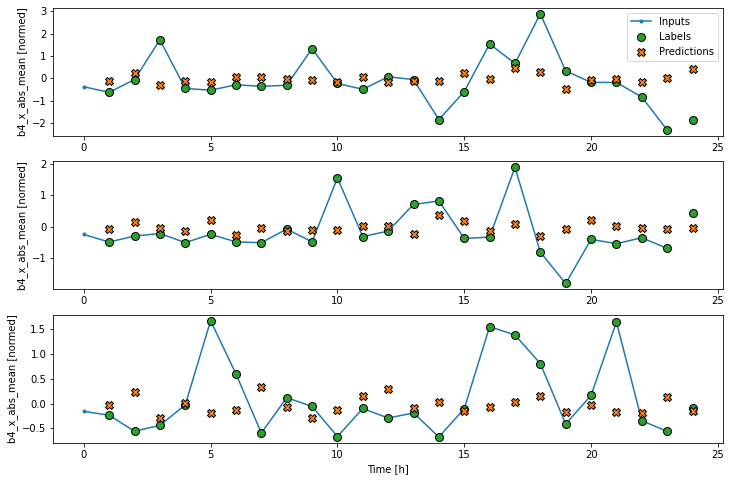

In [ ]:
wide_window.plot(linear, plot_col='b4_x_abs_mean')

## LSTM

Long Short-Term Memory (LSTM) networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems.

In [ ]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 8)
Output shape: (32, 24, 1)


In [ ]:
history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/20
47/47 [==============================] - 3s 29ms/step - loss: 0.9528 - mean_absolute_error: 0.7043 - val_loss: 1.1257 - val_mean_absolute_error: 0.7289
Epoch 2/20
47/47 [==============================] - 1s 18ms/step - loss: 0.9356 - mean_absolute_error: 0.6994 - val_loss: 1.1392 - val_mean_absolute_error: 0.7430
Epoch 3/20
13/13 [==============================] - 0s 6ms/step - loss: 1.1589 - mean_absolute_error: 0.7481


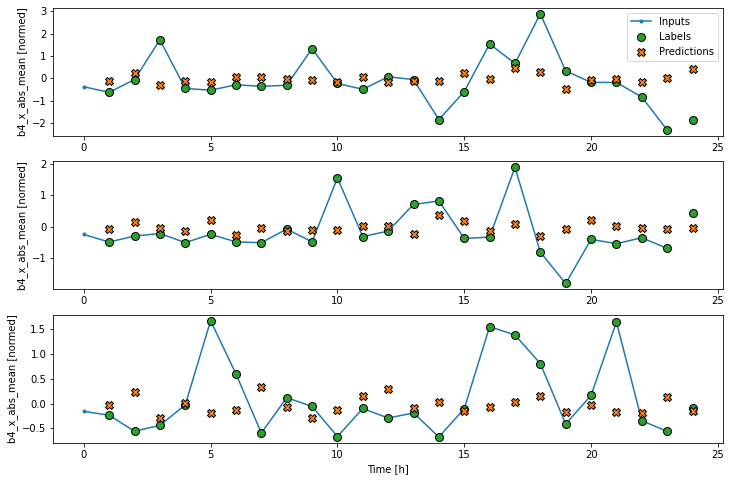

In [ ]:
wide_window.plot(linear, plot_col='b4_x_abs_mean')

# Multi-step models

In a multi-step prediction, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predicts a sequence of the future values.

In [ ]:
multi_val_performance = {}
multi_performance = {}

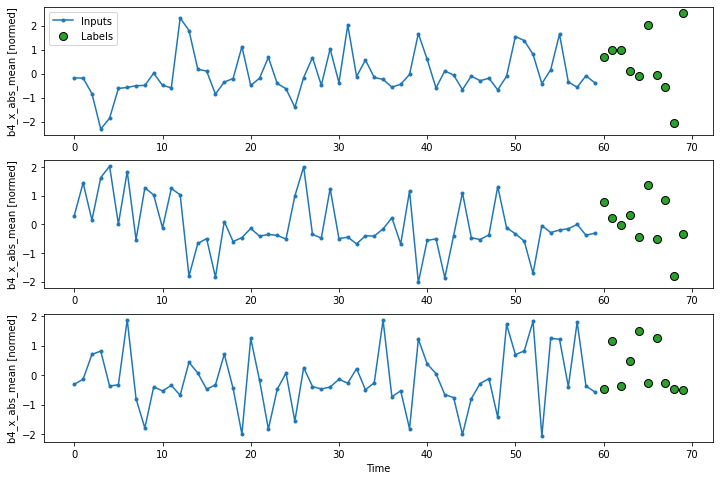

In [ ]:
OUT_STEPS = 10
multi_window = WindowGenerator(
  input_width=60,
  label_width=OUT_STEPS,
  shift=OUT_STEPS
)

multi_window.plot(plot_col='b4_x_abs_mean')

## Baseline

12/12 [==============================] - 0s 3ms/step - loss: 1.7639 - mean_absolute_error: 0.8391


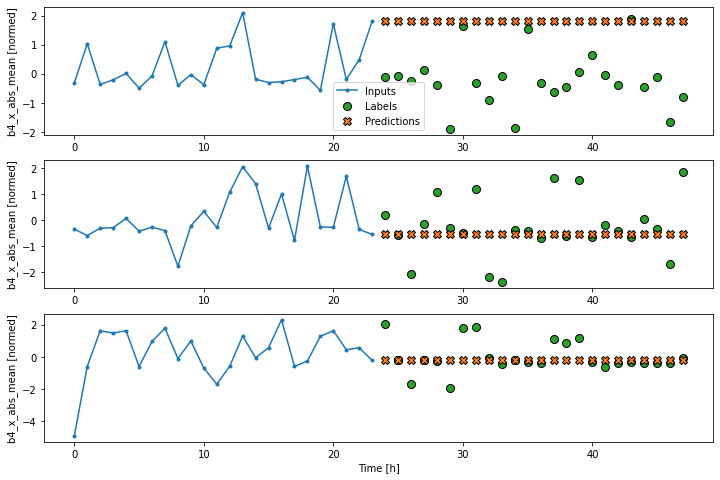

In [ ]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline, plot_col='b4_x_abs_mean')

## Linear

Epoch 1/20
46/46 [==============================] - 1s 12ms/step - loss: 1.0064 - mean_absolute_error: 0.6223 - val_loss: 0.8687 - val_mean_absolute_error: 0.6039
Epoch 2/20
46/46 [==============================] - 0s 8ms/step - loss: 1.0048 - mean_absolute_error: 0.6220 - val_loss: 0.8691 - val_mean_absolute_error: 0.6044
Epoch 3/20
12/12 [==============================] - 0s 3ms/step - loss: 0.8695 - mean_absolute_error: 0.6046


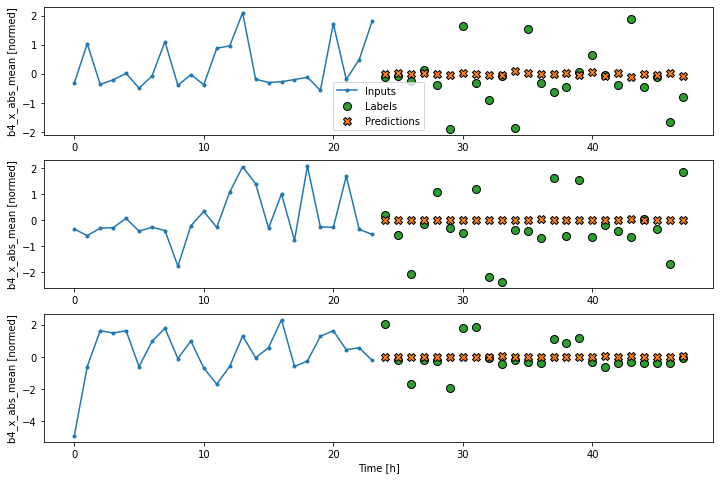

In [ ]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model, plot_col='b4_x_abs_mean')

## LSTM

Long Short-Term Memory (LSTM) networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems.

Epoch 1/20
45/45 [==============================] - 5s 48ms/step - loss: 1.0132 - mean_absolute_error: 0.6492 - val_loss: 0.8391 - val_mean_absolute_error: 0.6190
Epoch 2/20
45/45 [==============================] - 2s 34ms/step - loss: 1.0109 - mean_absolute_error: 0.6489 - val_loss: 0.8400 - val_mean_absolute_error: 0.6195
Epoch 3/20
12/12 [==============================] - 0s 8ms/step - loss: 0.8415 - mean_absolute_error: 0.6172


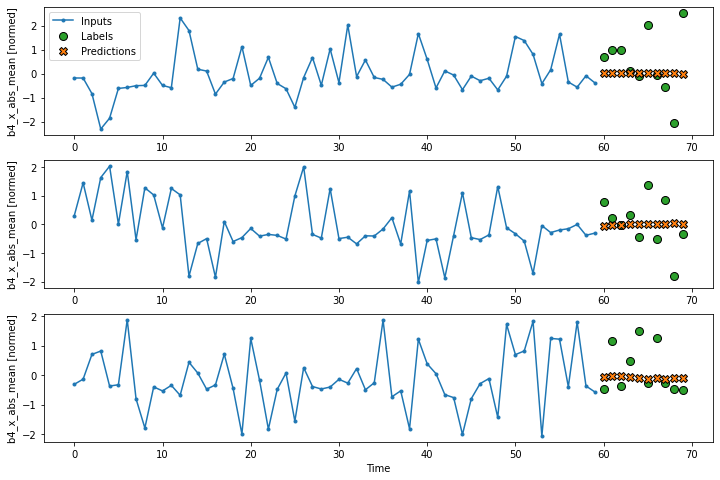

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS * num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model, plot_col='b4_x_abs_mean')

## Autoregresive RNN

In some cases it may be helpful for the model to decompose this prediction into individual time steps. Then, each model's output can be fed back into itself at each step and predictions can be made conditioned on the previous one, like in the classic Generating Sequences With Recurrent Neural Networks.

One clear advantage to this style of model is that it can be set up to produce output with a varying length.

In [ ]:
class ARLSTM(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()

    self.units = units
    self.out_steps = out_steps

    # Setup architecture
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

  def warmup(self, inputs):
    x, *state = self.lstm_rnn(inputs)
    prediction = self.dense(x)
    
    return prediction, state
  
  def call(self, inputs, training=None):
    predictions = []
    prediction, state = self.warmup(inputs)

    predictions.append(prediction)

    for n in range(1, self.out_steps):
      x = prediction
      x, state = self.lstm_cell(x, states=state, training=training)
      prediction = self.dense(x)
      predictions.append(prediction)

    predictions = tf.stack(predictions)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions


In [ ]:
arlstm_model = ARLSTM(units=32, out_steps=OUT_STEPS)
prediction, state = arlstm_model.warmup(multi_window.example[0])
print('Output shape (batch, time, features): ', arlstm_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 10, 10)


Epoch 1/20
45/45 [==============================] - 6s 45ms/step - loss: 1.0139 - mean_absolute_error: 0.6494 - val_loss: 0.8412 - val_mean_absolute_error: 0.6198
Epoch 2/20
45/45 [==============================] - 2s 35ms/step - loss: 1.0100 - mean_absolute_error: 0.6493 - val_loss: 0.8405 - val_mean_absolute_error: 0.6188
Epoch 3/20
45/45 [==============================] - 2s 36ms/step - loss: 1.0066 - mean_absolute_error: 0.6481 - val_loss: 0.8409 - val_mean_absolute_error: 0.6186
Epoch 4/20
12/12 [==============================] - 0s 10ms/step - loss: 0.8431 - mean_absolute_error: 0.6141


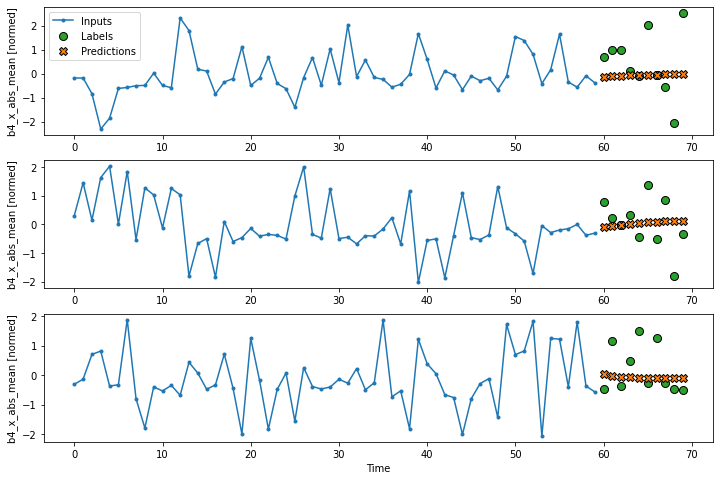

In [ ]:
history = compile_and_fit(arlstm_model, multi_window)

multi_val_performance['AR LSTM'] = arlstm_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = arlstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(arlstm_model, plot_col='b4_x_abs_mean')